In [1]:
from sqlalchemy import create_engine
from sqlalchemy import (
    Column,
    ForeignKey,
    Integer,
    String,
)
from sqlalchemy.orm import relationship
from sqlalchemy.orm import sessionmaker
import sqlalchemy as db
from sqlalchemy.ext.declarative import declarative_base

USERNAME = "user"
PASSWORD = "pass"
SERVER = "localhost"

# DEFINE THE ENGINE (CONNECTION OBJECT)
engine = create_engine(
    f"mysql+pymysql://{USERNAME}:{PASSWORD}@{SERVER}:3306/networksales", echo=True)

Base = declarative_base()

In [2]:
class Products(Base):
    __tablename__ = "Products"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    Product = Column(String(20), nullable=False)
    Speed = Column(Integer, nullable=False)
    Traffic = Column(Integer, nullable=False)
    Service = Column(String(20), nullable=False)
    Duration_month = Column(Integer, nullable=False)

    # Define a foreign key relationship to the 'Sales' table

    Sales = relationship('Sales', back_populates='Product')

    def __repr__(self):
        return f"<Products(id={self.id})>"

In [3]:
class Customers(Base):
    __tablename__ = "Customers"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    Customer = Column(String(20), nullable=False)

    # Define a foreign key relationship to the 'Sales' table

    Sales = relationship('Sales', back_populates='Customer')

    def __repr__(self):
        return f"<Customers(id={self.id})>"

In [4]:
class Time(Base):
    __tablename__ = "Time"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    Date = Column(String(20), nullable=False)

    # Define a foreign key relationship to the 'Sales' table

    Sales = relationship('Sales', back_populates='Time')

    def __repr__(self):
        return f"<Time(id={self.id}, Date={self.Date})>"

In [5]:
class Province(Base):
    __tablename__ = "Province"

    id = Column(Integer, primary_key=True, nullable=False)
    Province = Column(String(20), nullable=False)

    # Define a one-to-many relationship with 'City' table

    Sales = relationship('Sales', secondary="City", back_populates='Province')

    def __repr__(self):
        return f"<Province(id={self.id}, Province='{self.Province}')>"

In [6]:
class City(Base):
    __tablename__ = "City"

    id = Column(Integer, primary_key=True, autoincrement=True)
    City = Column(String(20), nullable=False)
    Province_id = Column(Integer, ForeignKey("Province.id"), nullable=False)

    Sales = relationship('Sales', secondary="Province", back_populates='City')

    def __repr__(self):
        return f"<City(id={self.id}, Province_id={self.Province_id})>"

In [7]:
class Sales(Base):
    __tablename__ = "Sales"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    Products_id = Column(Integer, ForeignKey('Products.id'), nullable=False)
    Customers_id = Column(Integer, ForeignKey('Customers.id'), nullable=False)
    Time_id = Column(Integer, ForeignKey('Time.id'), nullable=False)
    Province_id = Column(Integer, ForeignKey('Province.id'), nullable=False)
    City_id = Column(Integer, ForeignKey('City.id'), nullable=False)

    Product = relationship('Products', back_populates='Sales')
    Customer = relationship('Customers', back_populates='Sales')
    Time = relationship('Time', back_populates='Sales')
    Province = relationship('Province', back_populates='Sales')
    City = relationship('City', back_populates='Sales')

    def __repr__(self):
        return f"<Sales(id={self.id}, Products_id={self.Products_id}, Customers_id={self.Customers_id}, Time_id={self.Time_id}, Province_id={self.Province_id}, City_id={self.City_id})>"

## Part2. Visualization

In [8]:
from sqlalchemy import text

conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    SELECT Service, Speed, COUNT(*) as TotalSales
    FROM Sales
    JOIN Products ON Sales.Product_id = Products.id
    GROUP BY Service, Speed
"""
)

# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

import pandas as pd

df = pd.read_sql_query(sql_query, engine)

2023-09-30 04:57:55,821 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2023-09-30 04:57:55,822 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-09-30 04:57:55,828 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2023-09-30 04:57:55,829 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-09-30 04:57:55,833 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2023-09-30 04:57:55,835 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-09-30 04:57:55,841 INFO sqlalchemy.engine.Engine 
    SELECT Service, Speed, COUNT(*) as TotalSales
    FROM Sales
    JOIN Products ON Sales.Product_id = Products.id
    GROUP BY Service, Speed

2023-09-30 04:57:55,843 INFO sqlalchemy.engine.Engine [generated in 0.00204s] {}
2023-09-30 04:57:58,308 INFO sqlalchemy.engine.Engine 
    SELECT Service, Speed, COUNT(*) as TotalSales
    FROM Sales
    JOIN Products ON Sales.Product_id = Products.id
    GROUP BY Service, Speed

2023-09-30 04:57:58,310 INFO sqlalchemy.engine.Engine [cached since 2.47s ago] {}


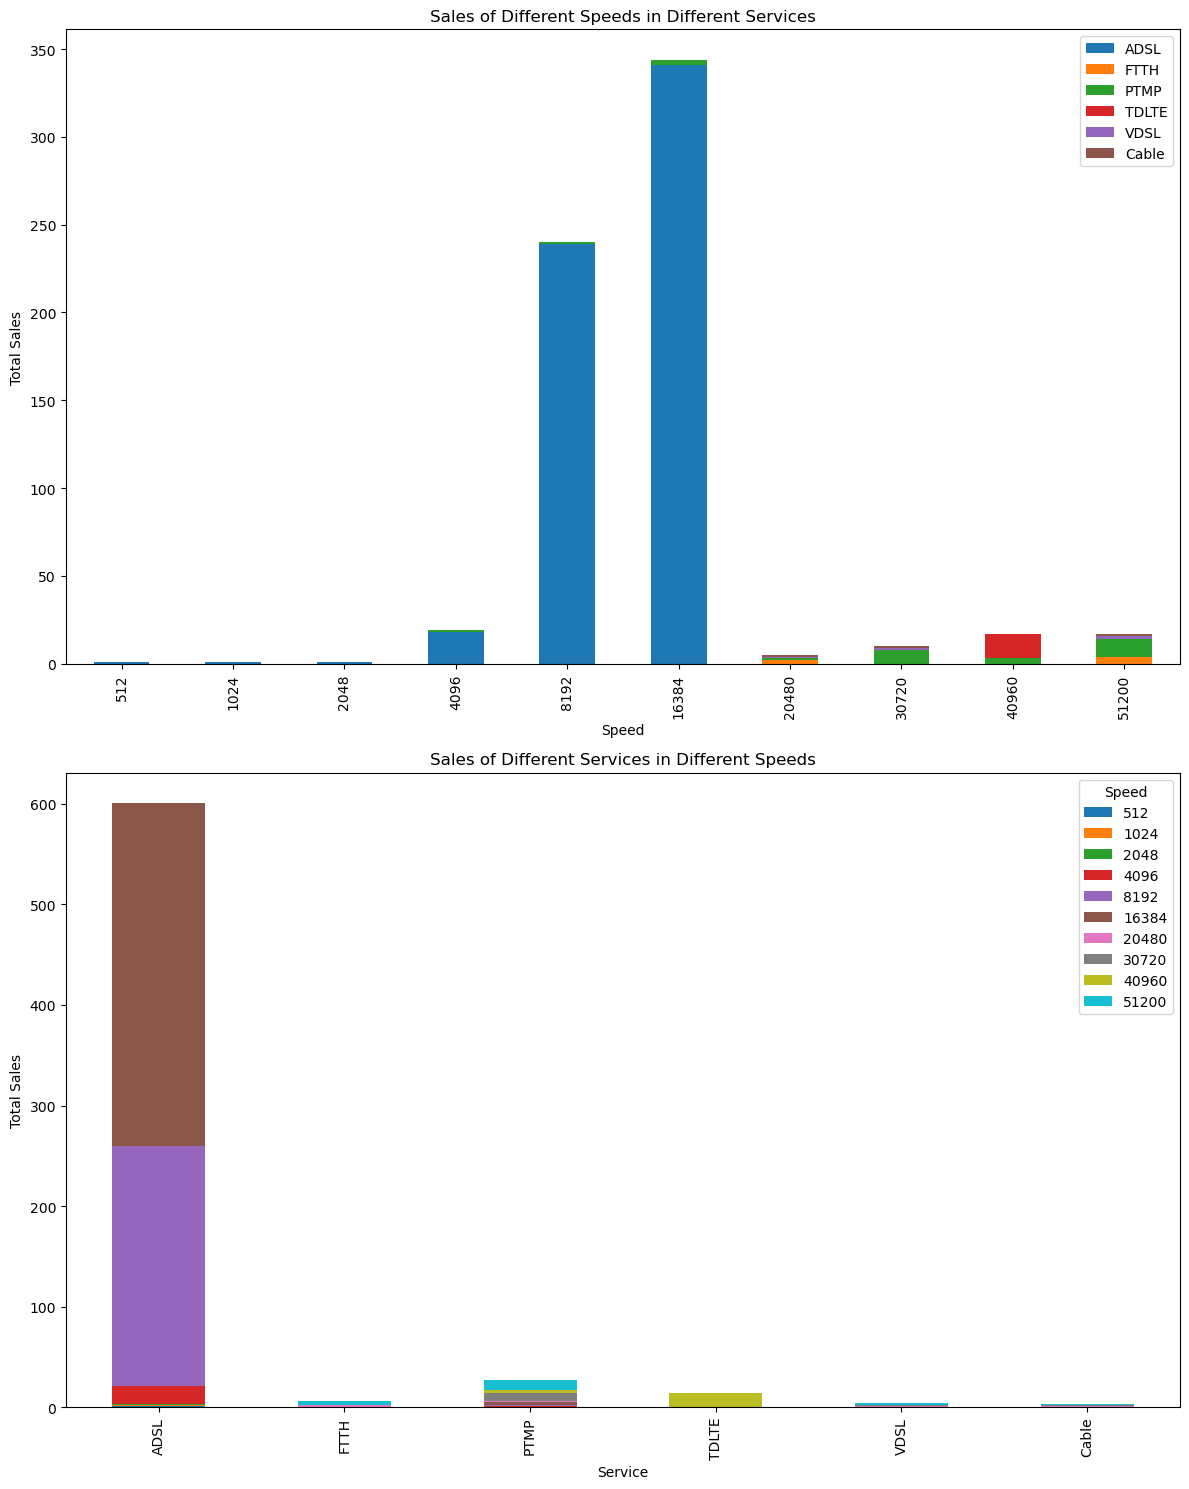

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from the query results
#df = pd.DataFrame(selected_rows, columns=['Service', 'Speed', 'TotalSales'])

# Pivot the data to get a column for each service
pivot_df1 = df.pivot(index='Speed', columns='Service', values='TotalSales')

# Pivot the data to get a column for each service (reversed)
pivot_df2 = df.pivot(index='Service', columns='Speed', values='TotalSales')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

# Plot the first subplot
pivot_df1.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Sales of Different Speeds in Different Services')
axes[0].set_xlabel('Speed')
axes[0].set_ylabel('Total Sales')

# Modify the legend in the first plot
legend_labels = pivot_df1.columns.tolist()
legend_labels[-1] = 'Cable'
axes[0].legend(labels=legend_labels)

# Plot the second subplot
pivot_df2.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Sales of Different Services in Different Speeds')
axes[1].set_xlabel('Service')
axes[1].set_ylabel('Total Sales')

# Modify the labels in the second plot
x_labels = pivot_df2.index.tolist()
x_labels[-1] = 'Cable'
axes[1].set_xticklabels(x_labels)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

## Part4. Next 10-days Product Sales Prediction

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

# Read Data
data = pd.read_csv('dataset.csv')

# Checking Missing Values in Date Column
print(data['Date'].isnull().any())
print(data['Date'].apply(lambda x: isinstance(x, str)).any())

False
True


In [11]:
data.head()

,Customer,Date,Product,Speed,Traffic,Service,Province,City,Duration_month
0,خالی,1401/04/15,TDLTE,40960,20480,TDLTE,فارس,جهرم,1
1,خالی,1401/04/22,TDLTE,40960,20480,TDLTE,خراسان رضوی,مشهد,1
2,خالی,1401/05/02,TDLTE,40960,20480,TDLTE,خراسان رضوی,مشهد,1
3,خالی,1401/04/07,TDLTE,40960,46080,TDLTE,البرز,کرج,1
4,خالی,1401/04/01,TDLTE,40960,102400,TDLTE,خوزستان,بندر ماهشهر,1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer        1595 non-null   object
 1   Date            1595 non-null   object
 2   Product         1595 non-null   object
 3   Speed           1595 non-null   int64 
 4   Traffic         1595 non-null   int64 
 5   Service         1595 non-null   object
 6   Province        1595 non-null   object
 7   City            1595 non-null   object
 8   Duration_month  1595 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 112.3+ KB


In [13]:
data.describe(include='all')

,Customer,Date,Product,Speed,Traffic,Service,Province,City,Duration_month
count,1595,1595,1595,1595.000000,1595.000000,1595,1595,1595,1595.000000
unique,1,80,8,NaN,NaN,6,15,36,NaN
top,خالی,1401/05/22,زیتون,NaN,NaN,ADSL,تهران,پردیس,NaN
freq,1595,43,766,NaN,NaN,1502,642,616,NaN
mean,NaN,NaN,NaN,14183.202508,143945.386834,NaN,NaN,NaN,2.567398
std,NaN,NaN,NaN,7654.131012,113956.880282,NaN,NaN,NaN,2.651851
min,NaN,NaN,NaN,512.000000,1076.000000,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,8192.000000,64512.000000,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,16384.000000,64512.000000,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,16384.000000,161280.000000,NaN,NaN,NaN,3.000000


In [14]:
! pip install persiantools

In [15]:
from persiantools.jdatetime import JalaliDate
import datetime

In [16]:
def func(row):
    date_str = row
    year, month, day = map(int, date_str.split("/"))
    date1 = JalaliDate(year, month, day).to_gregorian()
    formatted_date = datetime.date.strftime(date1, format="%Y-%m-%d")
    return formatted_date
data['Date'] = data['Date'].apply(func)

In [17]:
data.head()

,Customer,Date,Product,Speed,Traffic,Service,Province,City,Duration_month
0,خالی,2022-07-06,TDLTE,40960,20480,TDLTE,فارس,جهرم,1
1,خالی,2022-07-13,TDLTE,40960,20480,TDLTE,خراسان رضوی,مشهد,1
2,خالی,2022-07-24,TDLTE,40960,20480,TDLTE,خراسان رضوی,مشهد,1
3,خالی,2022-06-28,TDLTE,40960,46080,TDLTE,البرز,کرج,1
4,خالی,2022-06-22,TDLTE,40960,102400,TDLTE,خوزستان,بندر ماهشهر,1


In [18]:
df = data[data['Product']== 'زیتون']
df.head()

,Customer,Date,Product,Speed,Traffic,Service,Province,City,Duration_month
393,خالی,2022-06-22,زیتون,8192,32256,ADSL,آذربایجان غربی,ارومیه,3
394,خالی,2022-06-22,زیتون,8192,32256,ADSL,تهران,پردیس,3
395,خالی,2022-06-25,زیتون,8192,32256,ADSL,تهران,پردیس,3
396,خالی,2022-06-26,زیتون,8192,32256,ADSL,آذربایجان شرقی,سهند,3
397,خالی,2022-06-26,زیتون,8192,32256,ADSL,البرز,شهرک ابریشم,3


In [19]:
df = data[data['Product']== 'زیتون'].groupby('Date').count()['Product'].reset_index(drop=False)
df.head()

,Date,Product
0,2022-06-22,22
1,2022-06-23,6
2,2022-06-25,14
3,2022-06-26,28
4,2022-06-27,8


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     75 non-null     object
 1   Product  75 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


In [21]:
df.describe(include='all')

,Date,Product
count,75,75.000000
unique,75,NaN
top,2022-06-22,NaN
freq,1,NaN
mean,NaN,10.213333
std,NaN,6.539471
min,NaN,2.000000
25%,NaN,4.000000
50%,NaN,10.000000
75%,NaN,14.000000


C:\Users\Saleh\AppData\Local\Temp\ipykernel_19312\3027632477.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df["Product"], color = 'b')


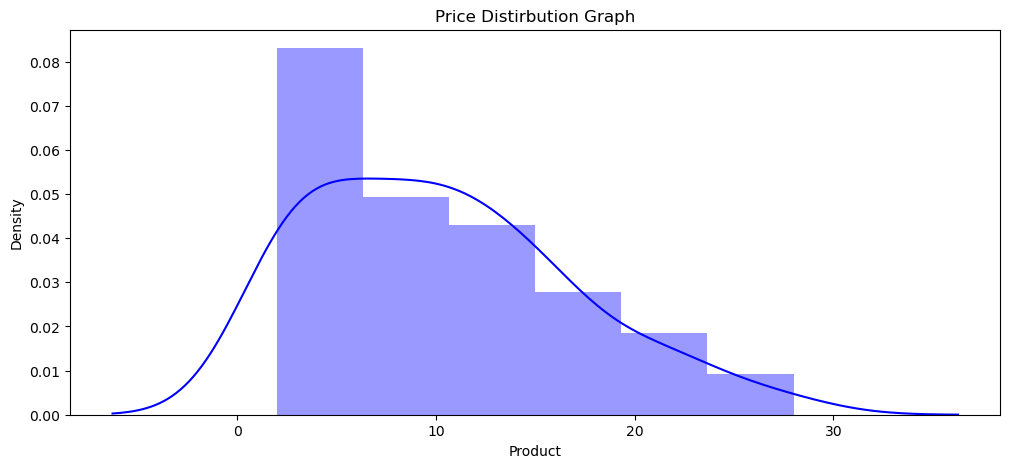

In [22]:
plt.figure(figsize=(12,5))
plt.title("Price Distirbution Graph")
ax = sns.distplot(df["Product"], color = 'b')

In [23]:
! pip install pmdarima
from pmdarima import auto_arima

In [24]:
model = auto_arima(df['Product'], start_p=0, start_q=0, max_p=5, max_q=5, m=7, start_P=0, seasonal=False, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)

forecast = model.predict(n_periods=10)

c:\Users\Saleh\miniconda3\envs\quera\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=543.407, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=530.549, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=541.438, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=508.856, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=501.000, Time=0.34 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=499.630, Time=0.50 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=499.329, Time=0.61 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=498.083, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=498.174, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=498.712, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=497.180, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=496.240, Time=0.3

In [25]:
df_2 = df['Product']

In [26]:
df_2.head()

0    22
1     6
2    14
3    28
4     8
Name: Product, dtype: int64

In [27]:
X = df_2.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [28]:
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=12.711638, expected=6.000000
predicted=12.104866, expected=22.000000
predicted=9.993802, expected=8.000000
predicted=8.249611, expected=4.000000
predicted=12.520958, expected=20.000000
predicted=11.478980, expected=10.000000
predicted=8.394397, expected=10.000000
predicted=12.453884, expected=18.000000
predicted=11.643971, expected=22.000000
predicted=11.035237, expected=2.000000
predicted=12.910714, expected=4.000000
predicted=17.042422, expected=10.000000
predicted=12.611279, expected=2.000000
predicted=8.943802, expected=14.000000
predicted=10.562885, expected=12.000000
predicted=10.091624, expected=2.000000
predicted=9.032987, expected=2.000000
predicted=10.363968, expected=20.000000
predicted=8.588556, expected=12.000000
predicted=5.013268, expected=6.000000
predicted=9.620373, expected=2.000000
predicted=10.709947, expected=10.000000
predicted=10.266564, expected=2.000000
predicted=7.148571, expected=4.000000
predicted=8.539481, expected=2.000000
predicted=6.297362, exp

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.556


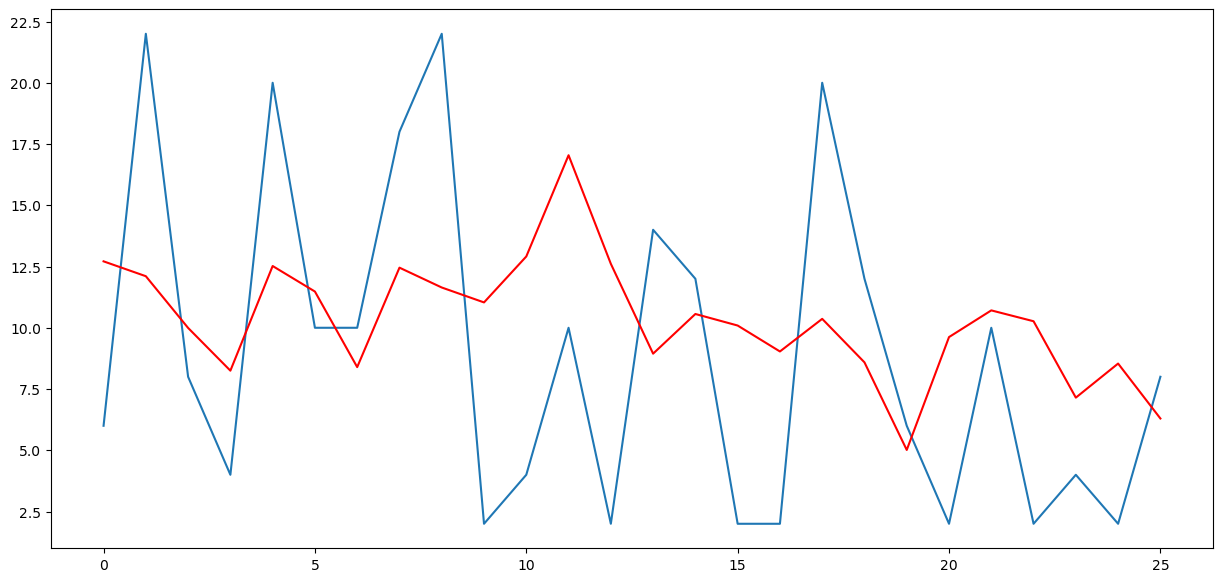

In [45]:
from matplotlib import pyplot

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Next Values Forecast:
75    6.144525
76    4.488129
77    5.517462
78    5.854841
79    5.418645
80    5.402453
81    5.557903
82    5.527491
83    5.480482
84    5.501958
Name: predicted_mean, dtype: float64


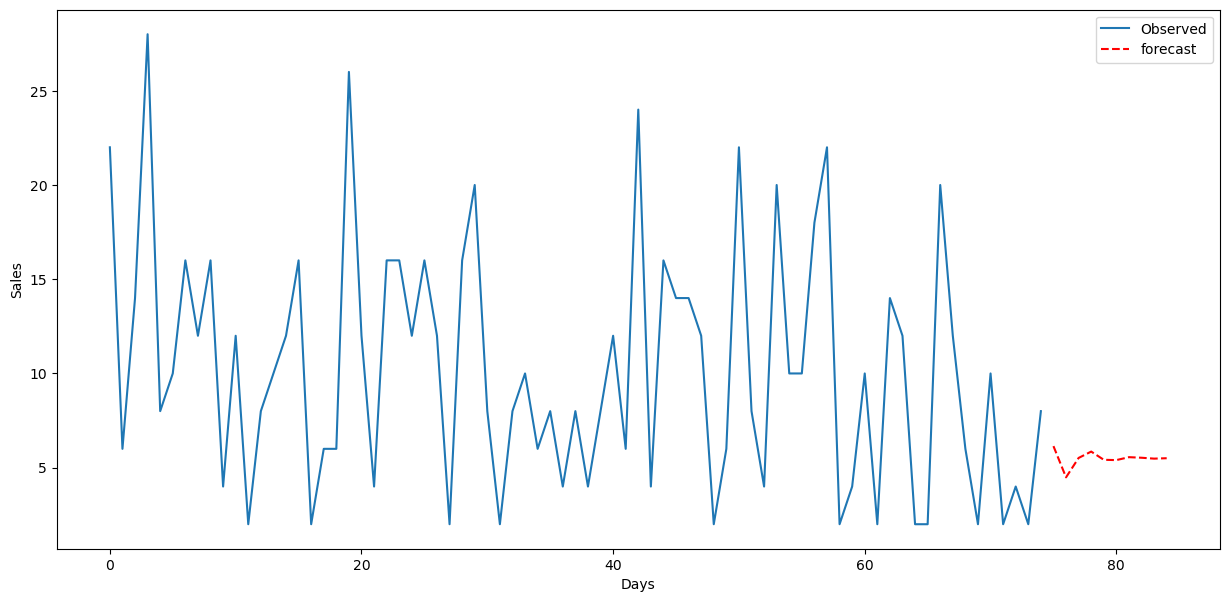

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Sales Data
datas = df['Product']
sales_series = pd.Series(df['Product'])

# ARIMA (p, d, q)
p, d, q = 2, 1, 1

# Building ARIMA Model
model = ARIMA(sales_series, order=(p, d, q))

# Model Fitting to Data
model_fit = model.fit()

# Predict Next 10 Days Sales Values
forecast_steps = 10
forecast_values = model_fit.forecast(steps=forecast_steps)

# Print Predicted Values
print("Next Values Forecast:")
print(forecast_values)

# Plot Predicted Values
plt.plot(sales_series, label='Observed')
plt.plot(range(len(datas), len(datas) + forecast_steps), forecast_values, 'r--', label='forecast')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Sales')
plt.show()

In [32]:
df_3 = df.copy()
df_3.columns=["Date","Sales"]
df_3.set_index('Date',inplace=True)

<Axes: >

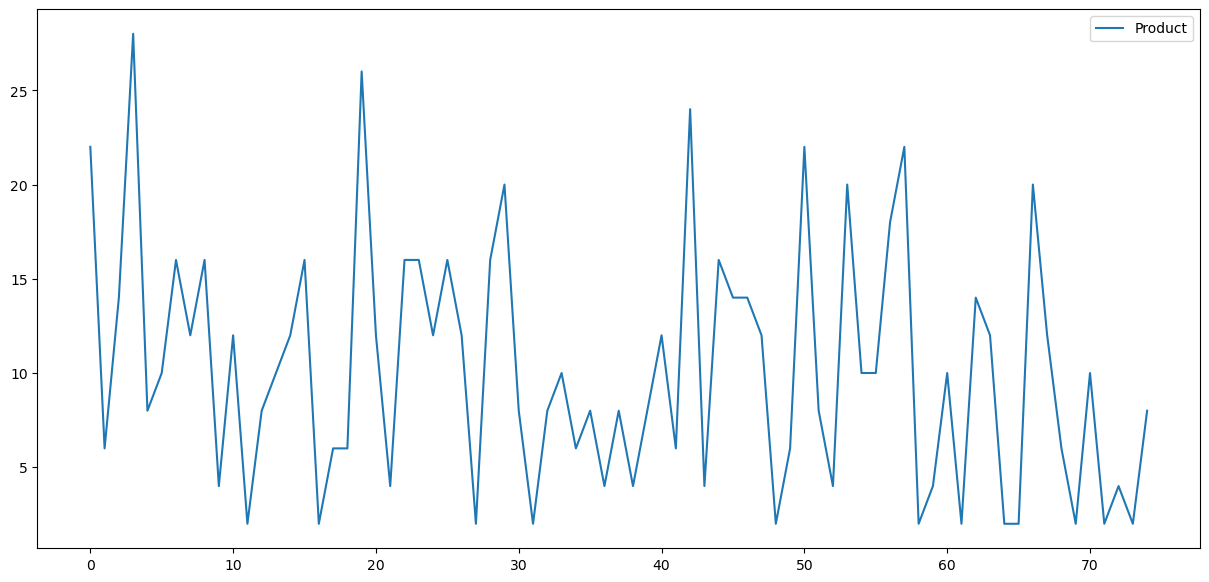

In [33]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df.plot()

In [34]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df_3['Sales'])
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['1. ADF Test Statistic','2. p-value','3. Num Of Lags Used','4. Num Of Observations Used For ADF Regression:']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
result = adfuller(df_3['Sales'])
stat = result[0]
p_value = result[1]
if p_value <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df_3['Sales'])

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
1. ADF Test Statistic : -6.986635298380661
2. p-value : 7.937740363706319e-10
3. Num Of Lags Used : 1
4. Num Of Observations Used For ADF Regression: : 73


In [35]:
df_3['Sales First Difference'] = df_3['Sales'] - df_3['Sales'].shift(1)
df_3['Seasonal First Difference'] = df_3['Sales'] - df_3['Sales'].shift(10)
df_3.head()

,Sales,Sales First Difference,Seasonal First Difference
Date,,,
2022-06-22,22,NaN,NaN
2022-06-23,6,-16.0,NaN
2022-06-25,14,8.0,NaN
2022-06-26,28,14.0,NaN
2022-06-27,8,-20.0,NaN


<Axes: xlabel='Date'>

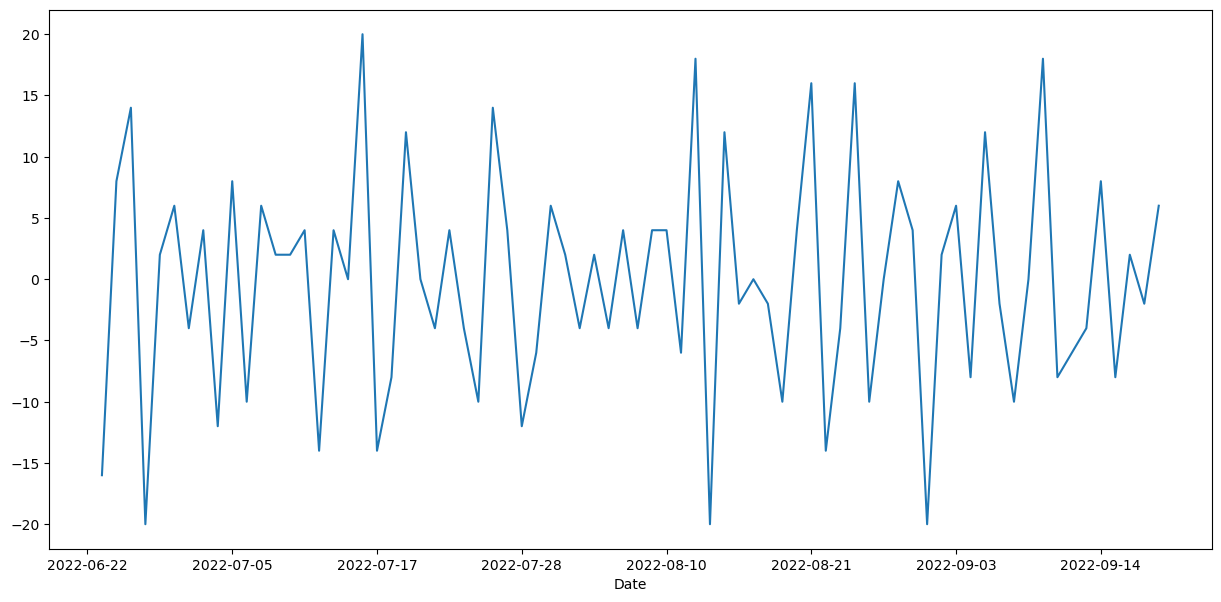

In [36]:
df_3['Sales First Difference'].plot()

<Axes: xlabel='Date'>

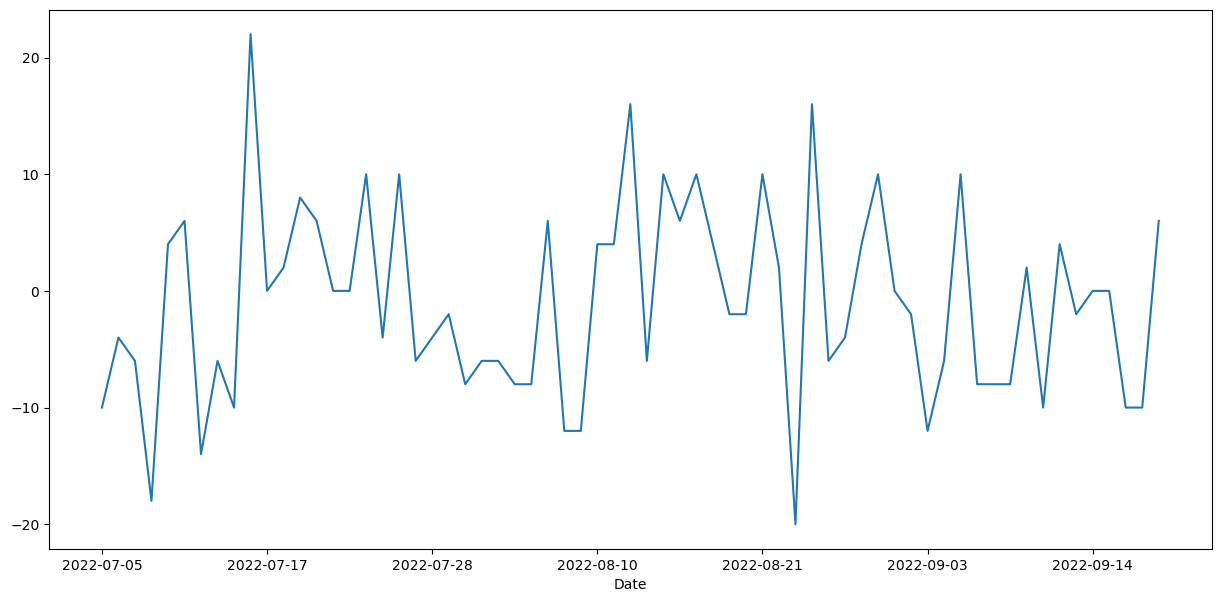

In [37]:
df_3['Seasonal First Difference'].plot()

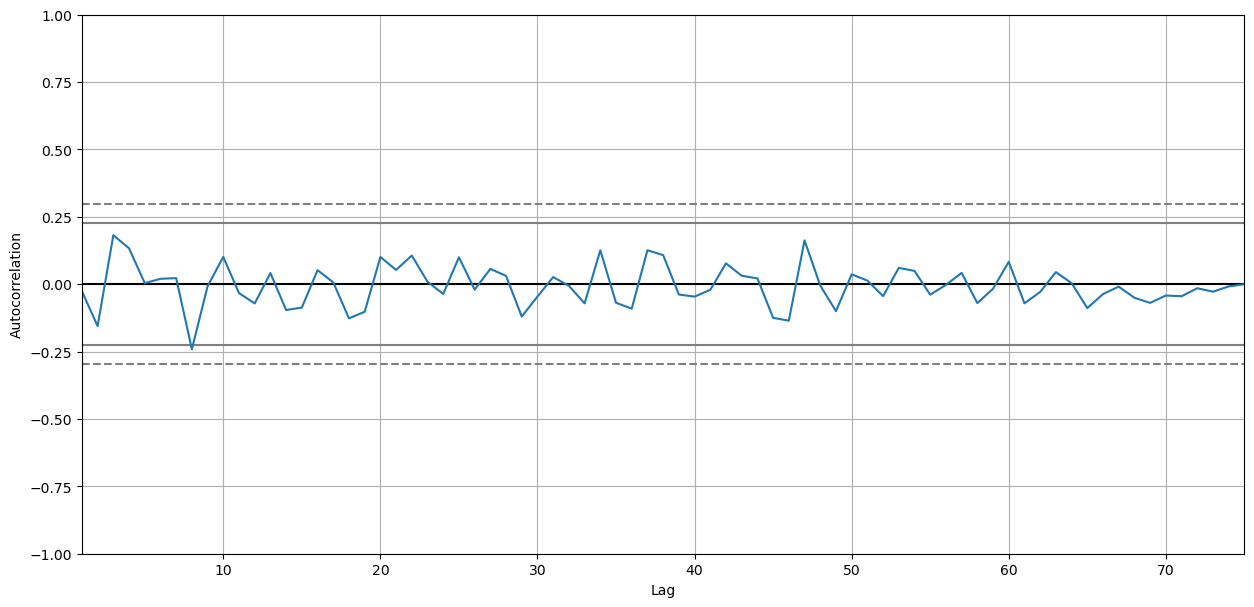

In [38]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_3['Sales'])
plt.show()

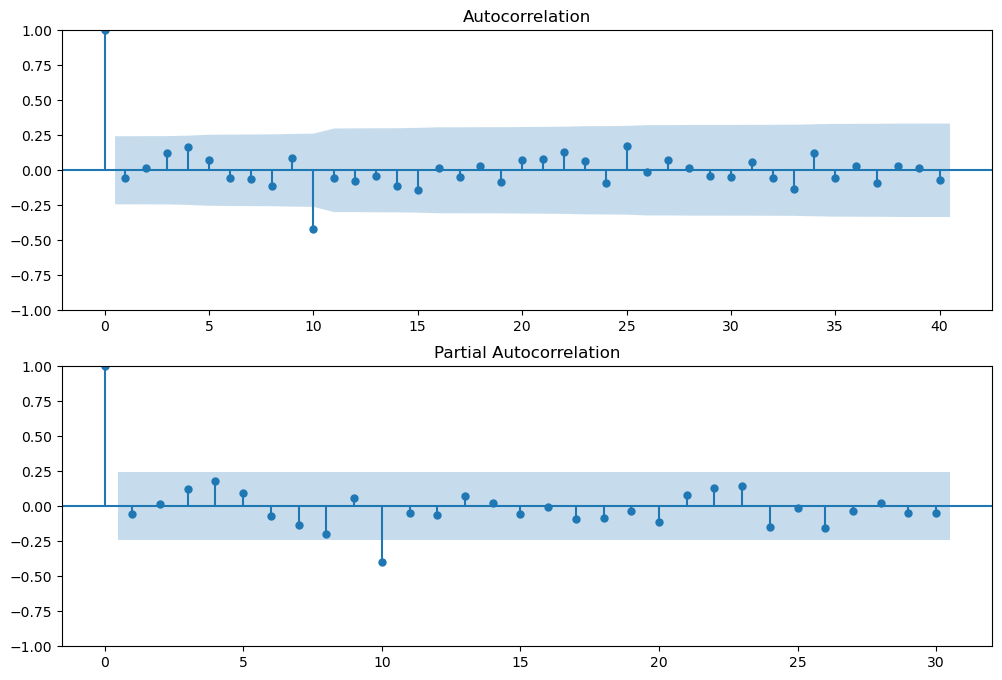

In [39]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_3['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_3['Seasonal First Difference'].dropna(),lags=30,ax=ax2)

In [40]:
# For non-seasonal data
#p=2, d=1, q=1

from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df_3['Sales'],order=(2,1,1))
model_fit=model.fit()
model_fit.summary()

c:\Users\Saleh\miniconda3\envs\quera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Saleh\miniconda3\envs\quera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Saleh\miniconda3\envs\quera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   75
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -243.146
Date:                Sat, 30 Sep 2023   AIC                            494.292
Time:                        04:58:47   BIC                            503.509
Sample:                             0   HQIC                           497.969
                                 - 75                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2319      0.163     -1.423      0.155      -0.551       0.088
ar.L2         -0.3478      0.158     -2.196      0.028      -0.658      -0.037
ma.L1         -0.7254      0.148     -4.905      0.000      -1.015      -0.436
sigma2        40.9162      7.503      5.453      0.000      26.210      55.623
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.91
Prob(Q):                              0.90   Prob(JB):                         0.14
Heteroskedasticity (H):               0.86   Skew:                             0.55
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

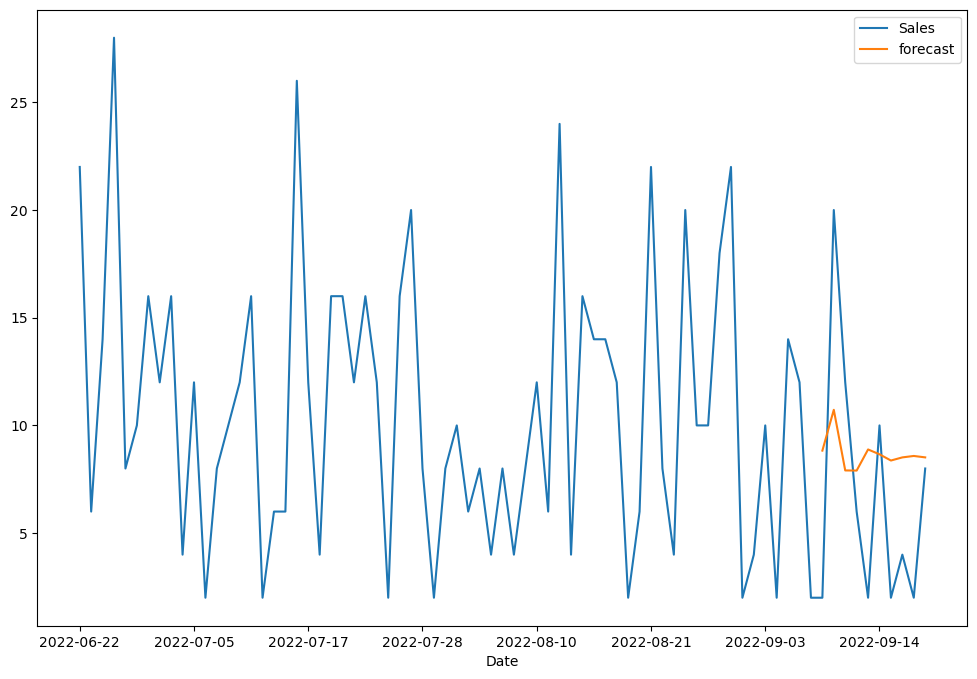

In [41]:
df_3['forecast']=model_fit.predict(start=65,end=74,dynamic=True)
df_3[['Sales','forecast']].plot(figsize=(12,8))

c:\Users\Saleh\miniconda3\envs\quera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Saleh\miniconda3\envs\quera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

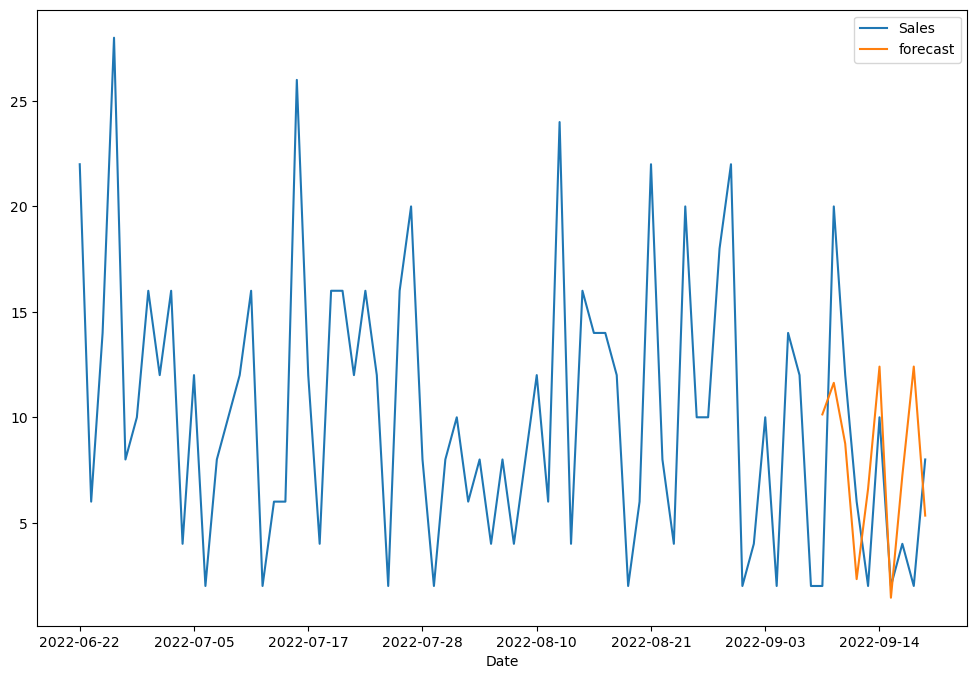

In [42]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_3['Sales'],order=(2, 1, 1),seasonal_order=(2,1,1,10))
results=model.fit()
df_3['forecast']=results.predict(start=65,end=74,dynamic=True)
df_3[['Sales','forecast']].plot(figsize=(12,8))

c:\Users\Saleh\miniconda3\envs\quera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Saleh\miniconda3\envs\quera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

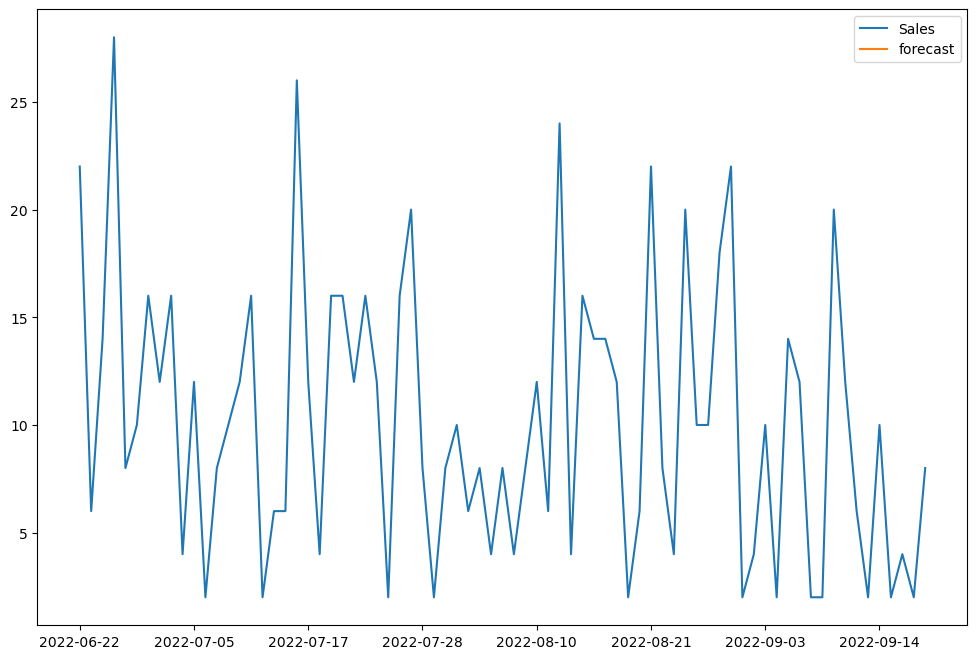

In [43]:
from pandas.tseries.offsets import DateOffset
import datetime

base = pd.to_datetime(df_3.index[-1], format='%Y-%m-%d')
future_dates = [(base + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(11)]

future_datest_df = pd.DataFrame(index=future_dates,columns=df_3.columns)

future_datest_df.tail()

future_df = pd.concat([df_3,future_datest_df])

future_df['forecast'] = results.predict(start = 75, end = 84, dynamic= True)
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))